In [1]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os

# It formats and keeps objects on a single line if it can or breaks them onto multiple lines
import pprint
pp = pprint.PrettyPrinter(indent=4, width=80, depth=None)

For the image processing I am using **skimage** and 
in order to **save the file** I am using joblib module, 
specifically the **.dump function**.

In [2]:
import joblib
from skimage.io import imread
from skimage.transform import resize

**It loads images from path,** resize them and write them as arrays to a dictionary, together with labels and metadata. The dictionary is written to **a pickle file**
named:
'{pklname}_{width}x{height}px.pkl'

In [3]:
def resize_all(src, pklname, include, width=150, height=None):
   
    """     
    src: path to data (str)
    pklname: path to output file (str)
    width: target width of the image in pixels (int)
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1}) images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [4]:
data_path = fr'./Image'
os.listdir(data_path)

['MonkeyHead',
 'Natural',
 'BearHead',
 'PigHead',
 'CatHead',
 'MouseHead',
 'WolfHead',
 'HumanHead',
 'PigeonHead',
 'CowHead',
 'SheepHead',
 'ChickenHead',
 'TigerHead',
 'EagleHead',
 'PandaHead',
 'RabbitHead',
 'DogHead',
 'DuckHead',
 'LionHead',
 'ElephantHead',
 'DeerHead']

Loads and **stores/pickles** the data into **a .pkl file**.
The pickle module is used for serializing and de-serializing Python object structures.

In [5]:
base_name= 'animal_faces'
width=80

include= {'ChickenHead', 'BearHead', 'ElephantHead', 'EagleHead', 'DeerHead', 'MonkeyHead', 'PandaHead'}

resize_all(src=data_path, pklname=base_name, width=width, include=include)

MonkeyHead
BearHead
ChickenHead
EagleHead
PandaHead
ElephantHead
DeerHead


In [6]:
# This module gives alternatives to Python’s general purpose built-in containers, dict, list, set, and tuple.
from collections import Counter 

Loads the data from the disk and prints a summary

In [7]:
data = joblib.load(f'{base_name}_{width}x{width}px.pkl')

print('keys: ', list(data.keys()))
print('number of samples: ', len(data['data']))
print('labels:', np.unique(data['label']))
print('image shape: ', data['data'][0].shape)
print('description: ', data['description'])
 
Counter(data['label'])

keys:  ['description', 'label', 'filename', 'data']
number of samples:  716
labels: ['Bear' 'Chicken' 'Deer' 'Eagle' 'Elephant' 'Monkey' 'Panda']
image shape:  (80, 80, 3)
description:  resized (80x80) images in rgb


Counter({'Monkey': 100,
         'Bear': 101,
         'Chicken': 100,
         'Eagle': 97,
         'Panda': 117,
         'Elephant': 100,
         'Deer': 101})

#### Printing the unique values

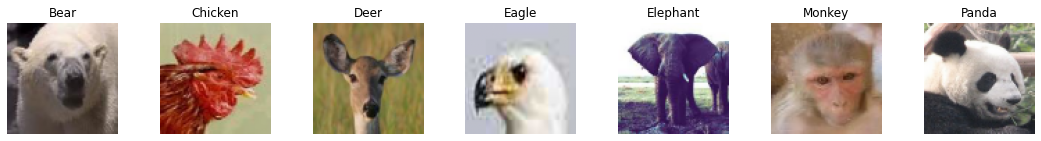

In [8]:
# Uses np.unique to get all unique values in the list of labels
def get_unique(data):
    return np.unique(data)

labels = get_unique(data['label'])
 
# Sets up the matplotlib figure, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# Make a plot for every label.
# zip takes iterables and makes a colletion
for ax, label in zip(axes, labels):
    
    # The index method returns the index of the first item corresponding to its search string, label in this case
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [9]:
X = np.array(data['data']) # input data 
y = np.array(data['label']) # results 

Here is split the data into a test set and a training set. 
With the **train_test_split** function from scikit-learn **70%** of the total set are used for training and the remaining for testing.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

# Processing

In order to **reduce the amount of the features** from an image there is a classic approach - **Histogram of Oriented Gradients** and Support Vector Machines. 

**A feature descriptor** is a representation of an image or an image patch that simplifies the image by extracting useful information and throwing away extraneous information.

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.feature import hog

#### Convert an array of RGB images to grayscale

In [12]:
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        # returns itself
        return self
 
    def transform(self, X, y=None):
        # perform the transformation and return an array
        return np.array([skimage.color.rgb2gray(img) for img in X])

**Calculates hog features for each img**

Expects an array of 2d arrays (1 channel images)
https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

In [13]:
class HogTransformer(BaseEstimator, TransformerMixin):
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

# Training

In [14]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer, PolynomialFeatures

import skimage


from sklearn.pipeline import Pipeline
from sklearn import svm
 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(4, 4), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SVC(random_state=42, max_iter=1000))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print('Percentage correct: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))


Percentage correct:  93.02325581395348


### Grid search

In the first section are set HOG parameters in order to test, which adjustments are doing the best. In the second, SGD and SVM DecisionTreeClassifier and RandomForestClassifier are tested.

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)]
    },
    {
        'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(8, 8)],
         'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear'),
             DecisionTreeClassifier(max_depth=5),
             RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, n_jobs=-1),
             
         ],
        'scalify': [
            StandardScaler(),
        ]
    }
]

In [16]:
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/Users/petemihaylov/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   39.2s finished


# Metrics

In [17]:
# Saves the model to disk
joblib.dump(grid_res, 'hog_model.pkl');

In [18]:
# Description of the best performing object, a pipeline in our case.
grid_res.best_estimator_

Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(orientations=8)),
                ('scalify', StandardScaler()),
                ('classify', SVC(max_iter=1000, random_state=42))])

In [19]:
# The highscore during the search
grid_res.best_score_

0.9461386138613861

In [20]:
pp.pprint(grid_res.best_params_)

{   'hogify__cells_per_block': (3, 3),
    'hogify__orientations': 8,
    'hogify__pixels_per_cell': (8, 8)}


In [21]:
y_pred = grid_res.predict(X_test)

# Confusion matrix

In [22]:
from sklearn.metrics import confusion_matrix
cmx = confusion_matrix(y_test, y_pred)
cmx

array([[26,  0,  0,  0,  0,  2,  0],
       [ 1, 30,  0,  1,  0,  1,  0],
       [ 0,  1, 29,  0,  0,  0,  0],
       [ 0,  2,  0, 28,  0,  0,  1],
       [ 2,  0,  0,  0, 29,  0,  0],
       [ 0,  0,  0,  0,  0, 32,  3],
       [ 0,  0,  0,  0,  0,  0, 27]])

The largest values are on the diagonal, which means that most predictions should be correct. To visualise this more clearly as an image:

* First, the matrix is normalised to 100, by dividing every value by the sum of its row (the number of actual items with a specific label).


* Second, The **main diagonal** is set to **0** in order to focus on the **wrong predictions**.


 ['Bear', 'Chicken', 'Deer', 'Eagle', 'Elephant', 'Monkey', 'Panda']


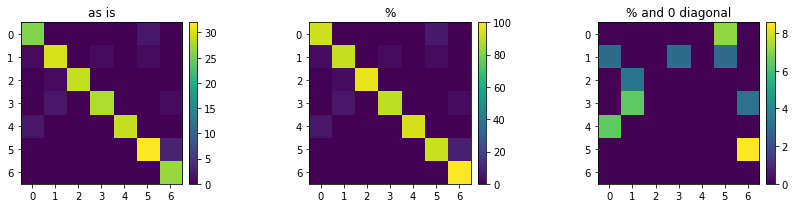

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Author Patrick Steegstra
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx)
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))

In conclusion, there is a high percentage of monkeys being classified as pandas. It was created a basic model to classify images based on their HOG features with almost a generic methodology.